In [1]:
# A single-file scripts for running the ellipse experiment, 
# the confounders 'angle' and 'position' were included in Eq. 4 during model training.
import pandas as pd
import numpy as np
import cv2 as cv
import glob
import os
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision.models as models
from PIL import Image, ImageOps
import cv2
import imgaug as ia
from imgaug import augmenters as iaa
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader,TensorDataset
import sys
import torch.optim as optim
import math
sys.path.append(".")
from sklearn.feature_selection import mutual_info_regression
import dcor



In [2]:
# define the autoencoder model------------------------------------


class Encoder(nn.Module):
    def __init__(self, nc, nef, nz, isize, device):
        super(Encoder, self).__init__()

        # Device
        self.device = device

        # Encoder: (nc, isize, isize) -> (nef*8, isize//16, isize//16)
        self.encoder = nn.Sequential(
            nn.Conv2d(nc, nef, 4, 2, padding=1),
            nn.LeakyReLU(0.2, True),
            nn.BatchNorm2d(nef),

            nn.Conv2d(nef, nef*2, 4, 2, padding=1),
            nn.LeakyReLU(0.2, True),
            nn.BatchNorm2d(nef*2),

            nn.Conv2d(nef*2, nef*4, 4, 2, padding=1),
            nn.LeakyReLU(0.2, True),
            nn.BatchNorm2d(nef*4),

            nn.Conv2d(nef*4, nef*8, 4, 2, padding=1),
            nn.LeakyReLU(0.2, True),
            nn.BatchNorm2d(nef*8)
        )

        # Map the encoded feature map to the latent vector of mean, (log)variance
        out_size = isize // 16
        self.mean = nn.Linear(nef*8*out_size*out_size, nz)
        self.logvar = nn.Linear(nef*8*out_size*out_size, nz)

    def reparametrize(self, mean, logvar):
        std = logvar.mul(0.5).exp_()
        multi_norm = torch.FloatTensor(std.size()).normal_().to(self.device)
        multi_norm = Variable(multi_norm)
        return multi_norm.mul(std).add_(mean)

    def forward(self, inputs):
        # Batch size
        batch_size = inputs.size(0)
        # Encoded feature map
        hidden = self.encoder(inputs)
        # Reshape
        hidden = hidden.view(batch_size, -1)
        # Calculate mean and (log)variance
        mean, logvar = self.mean(hidden), self.logvar(hidden)
        # Sample
        latent_z = self.reparametrize(mean, logvar)
        #latent_z = mean
        return latent_z, mean, logvar

class Decoder(nn.Module):
    def __init__(self, nc, ndf, nz, isize):
        super(Decoder, self).__init__()

        # Map the latent vector to the feature map space
        self.ndf = ndf
        self.out_size = isize // 16
        self.decoder_dense = nn.Sequential(
            nn.Linear(nz, ndf*8*self.out_size*self.out_size),
            nn.ReLU(True)
        )
        # Decoder: (ndf*8, isize//16, isize//16) -> (nc, isize, isize)
        self.decoder_conv = nn.Sequential(
            nn.UpsamplingNearest2d(scale_factor=2),
            nn.Conv2d(ndf*8, ndf*4, 3, padding=1),
            nn.LeakyReLU(0.2, True),
            nn.BatchNorm2d(ndf*4, 1.e-3),

            nn.UpsamplingNearest2d(scale_factor=2),
            nn.Conv2d(ndf*4, ndf*2, 3, padding=1),
            nn.LeakyReLU(0.2, True),
            nn.BatchNorm2d(ndf*2, 1.e-3),
        
            nn.UpsamplingNearest2d(scale_factor=2),
            nn.Conv2d(ndf*2, ndf, 3, padding=1),
            nn.LeakyReLU(0.2, True),
            nn.BatchNorm2d(ndf, 1.e-3),

            nn.UpsamplingNearest2d(scale_factor=2),
            nn.Conv2d(ndf, nc, 3, padding=1),
            nn.ReLU(True)
        )

    def forward(self, input):
        batch_size = input.size(0)
        hidden = self.decoder_dense(input).view(
            batch_size, self.ndf*8, self.out_size, self.out_size)
        output = self.decoder_conv(hidden)
        return output

class VAE(nn.Module):
    def __init__(self, nc=1, ndf=4, nef=4, nz=8, isize=64, device=torch.device("cuda:0"), is_train=True):
        super(VAE, self).__init__()

        self.nz = nz
        # Encoder
        self.encoder = Encoder(nc=nc, nef=nef, nz=nz, isize=isize, device=device)
        # Decoder
        self.decoder = Decoder(nc=nc, ndf=ndf, nz=nz, isize=isize)
        self.pe = nn.Linear(nz, 1, bias=False)
        if is_train == False:
            for param in self.encoder.parameters():
                param.requires_grad = False
            for param in self.decoder.parameters():
                param.requires_grad = False

    def forward(self, x):
        latent_z, mean, logvar = self.encoder(x)
        rec_x = self.decoder(latent_z)
        zp = self.pe(latent_z)

        return rec_x, mean, logvar, latent_z, zp, 
    
    def encode(self, x):
        latent_z, _, _ = self.encoder(x)
        return latent_z

    def decode(self, z):
        return self.decoder(z)

In [3]:
#loss functions---------------------------------

def torch_corr(input1, input2, device):  #The correlation loss function

    mean_1 = torch.mean(input1)
    mean_2 = torch.mean(input2)
    var_1 = torch.var(input1)
    var_2 = torch.var(input2)
    vector_mean1 = mean_1*torch.ones([len(input1)]).to(device)
    vector_mean2 = mean_2*torch.ones([len(input2)]).to(device)
    #print(input2, vector_mean2)
    diff_1 = input1 - vector_mean1
    diff_2 = input2 - vector_mean2

    exp = torch.mul(diff_1,diff_2)
    exp = torch.sum(exp)   


    exp = exp / len(input1)
    exp = exp / torch.sqrt(var_1*var_2)
    return abs(exp)


class KLDLoss(nn.Module):
    def __init__(self, reduction='sum'):
        super(KLDLoss, self).__init__()
        self.reduction = reduction

    def forward(self, mean, logvar):
        # KLD loss
        kld_loss = -0.5 * torch.sum(1 + logvar - mean.pow(2) - logvar.exp(), 1)
        # Size average
        if self.reduction == 'mean':
            kld_loss = torch.mean(kld_loss)
        elif self.reduction == 'sum':
            kld_loss = torch.sum(kld_loss)
        return kld_loss
    


In [4]:
# data loader----------------------------------


class ImgAugTransform:
  def __init__(self):
    self.aug = iaa.Sequential([
        iaa.Fliplr(0.5),
        iaa.Sometimes(0.4,\
            iaa.ContrastNormalization((0.8, 1.2), per_channel=0.5)),
        iaa.Sometimes(0.4,\
            iaa.GaussianBlur(sigma=(0, 0.2))),
    ])
      
  def __call__(self, img):
    img = np.array(img)
    img = self.aug.augment_image(img)
    return img

class ImageDataset(Dataset):
    def __init__(self, paths_image,is_aug=False):
        super(ImageDataset, self).__init__()

        # Length
        self.length = len(paths_image)
        # Image path
        self.paths_image = paths_image

        # Augment
        self.is_aug = is_aug
        self.transform = transforms.Compose([
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
            ImgAugTransform(),
            lambda x: Image.fromarray(x),
        ])
        # Preprocess
        self.output = transforms.Compose([
            transforms.Resize((64, 64)),
            transforms.ToTensor(),
            ])

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        # Image
        img = Image.open(self.paths_image[idx].strip())  # Strip any extra whitespace or newline characters
        img = self.output(img)

        # File name parsing
        file_name = self.paths_image[idx].strip()  # Ensure no whitespace issues
        file_name_no_ext = file_name.split('/')[-1].replace('.png', '')  # Get just the filename without the path or extension

        # Split filename into components
        split_file_name = file_name_no_ext.split('_')
        #print(split_file_name)
        if len(split_file_name) == 5:  # Check for correct format (imageID_area_rotation_position_brightness)
            imageID = split_file_name[0]
            area = float(split_file_name[1])           # Convert area to float
            rotation = float(split_file_name[2])       # Convert rotation to float
            position = float(split_file_name[3])       # Convert position to float
            brightness = float(split_file_name[4])     # Convert brightness to float

            # Normalize brightness if needed
            normalized_brightness = float(brightness/255)
        else:
            raise ValueError("Filename format is incorrect. Ensure it follows '{imageID}_{area}_{rotation}_{position}_{brightness}.png'")

        return img, area, rotation, position, normalized_brightness, imageID
    


# this dataloader was implemented with class 'ImageDataset' for dynamic memory control
def get_celeba_loaders(batch_train, batch_test):
    f_train = open('/ellipse_dataset/folds_split/train_fold_1.txt','r')      # paths for input
    file_list_train = f_train.readlines()

    f_test = open('/ellipse_dataset/folds_split/test_fold_1.txt','r')      # paths for input
    file_list_test = f_test.readlines()

    datasets = {
        "train":  ImageDataset(file_list_train,True),
        "test": ImageDataset(file_list_test, False)
    }

    dataloaders = {
        "train": DataLoader(  datasets["train"],  batch_size=batch_train, shuffle=True),
        "test": DataLoader( datasets["test"], batch_size=batch_test, shuffle=False)
    }
    return dataloaders




In [5]:
# display functions--------------------------


if "DISPLAY" not in os.environ:
    plt.switch_backend("Agg")

def plot_loss(dirname, history):
    """ Plot loss """

    plot_train = np.array(history["train"])
    is_val = ("test" in history.keys())
    if is_val:
        plot_val = np.array(history["test"])

    if not os.path.exists(dirname):
        os.makedirs(dirname)

    # epochs
    n_epochs = len(plot_train)

    # X axis
    x = [i for i in range(1, n_epochs+1)]
    
    # plot loss
    fig = plt.figure()
    fig.patch.set_facecolor('white')

    plt.xlabel('epoch')
    plt.plot(x, plot_train[:], label='train loss')
    if is_val:
        plt.plot(x, plot_val[:], label='test loss')

    plt.legend()
    plt.savefig(os.path.join(dirname,'loss.png'))
    plt.close()

def imsave(x, rec_x, path, row=2, col=2):
    """ Save the first row*col images """
    #print(x.size())
    #exit(0)
    # Save dir
    save_dir = os.path.dirname(path)
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    # To cpu, numpy, uint8 format and (num, h, w, c) shape
    in_imgs = (x.clone().cpu().detach().numpy()[:row*col]*255)\
        .astype(np.uint8).transpose(0, 2, 3, 1)[:, :, :, ::-1]
    out_imgs = (rec_x.clone().cpu().detach().numpy()[:row*col]*255)\
        .astype(np.uint8).transpose(0, 2, 3, 1)[:, :, :, ::-1]

    # Reshape
    in_imgs = cv2.vconcat([cv2.hconcat([in_imgs[i+j] for j in range(0, col)])
        for i in range(0, row*col, col)])
    out_imgs = cv2.vconcat([cv2.hconcat([out_imgs[i+j] for j in range(0, col)])
        for i in range(0, row*col, col)])
   # print(in_imgs.shape)
    #exit(0)
    # Concat
    h, _,  = in_imgs.shape
    margin_shape = (h, 5 )
    margin = np.ones(margin_shape, np.uint8) * 255
    concat_imgs = cv2.hconcat([in_imgs, margin, out_imgs])

    # Save
    cv2.imwrite(path, concat_imgs)

def imsave_inp(x, path, row=1, col=11):
    """ Save the interpolated images """

    # Save dir
    save_dir = os.path.dirname(path)
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    # To cpu, numpy, uint8 format and (num, h, w, c) shape
    in_imgs = (x.clone().cpu().detach().numpy()[:row*col]*255)\
        .astype(np.uint8).transpose(0, 2, 3, 1)[:, :, :, ::-1]

    # Reshape
    in_imgs = cv2.vconcat([cv2.hconcat([in_imgs[i+j] for j in range(0, col)])
        for i in range(0, row*col, col)])

    # Save
    cv2.imwrite(path, in_imgs)

class Logger:
    def __init__(self, path):
        self.f = open(path, 'w')

    def __del__(self):
        self.f.close()

    def write(self, text):
        self.f.write(text+"\n")
        self.f.flush()
        print(text)

In [55]:
# training------------------------

# Device
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
epochs=150
batch_train = 32
batch_test = 64
eta = 2.0 ## see Eq. 3 in the paper     if eta==0, then disable confounder correction
lambda_par=8000 # see Eq. 5 in the paper
# Dataloader
dataloaders = get_celeba_loaders(batch_train, batch_test) # train batch size : 16;  test batch size: 64
# Model
model = VAE(device=device).to(device)


reconst_criterion = nn.MSELoss(reduction='sum')

kld_criterion = KLDLoss(reduction='sum')

# Solver
optimizer = optim.Adam(model.parameters(), lr=0.005)
# Scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, 1, gamma=0.97, last_epoch=-1)

#----model lr, see t^=LR(zp) in the manuscript

model_lr = torch.nn.Linear(1,1).to(device)
optimizer_lr = optim.Adam(model_lr.parameters(), lr=0.05)
scheduler_lr = optim.lr_scheduler.StepLR(optimizer_lr, 1, gamma=0.97, last_epoch=-1)
#----
# Log
logdir = './log/pvae'

if not os.path.exists(logdir):
    os.makedirs(logdir)
# Logger
logger = Logger(os.path.join(logdir, "log.txt"))
# History
history = {"train": [], "test": []}


# Start training
for epoch in range(epochs):
    num_list, pos_list, rot_list, zp_list, bri_list,logit_out_list = [],[],[],[],[],[]
    mse_loss_total = 0
    for phase in ["train", "test"]:
        if phase == "train":
            model.train(True)
            model_lr.train(True)
            logger.write(f"\n----- Epoch {epoch+1} -----")
        else:
            model.train(False)
            model_lr.train(False)
        # Loss
        running_loss = 0.0
        # Data num
        data_num = 0

        i = 0
        i_test = 0
        for data in dataloaders[phase]:
            x = data[0].to(device)
            num_t = data[1].to(device) #area
            rot_t = data[2].to(device) #ratation
            pos_t = data[3].to(device) #position
            bri_t = data[4].to(device) #brightness
            id_name = data[5]
            #print(num_t,col_t,red_t,id_name)
            #print(num_t, col_t,id_name)
            #exit(0)
            # Optimize params

            if phase == "train":
                optimizer.zero_grad()
                if len(num_t) != batch_train:
                    continue
                # Pass forward
                x = x.to(device)
                rec_x, mean, logvar, latent_z , zp  = model(x)
                # Calc loss
                zp = zp.view([len(num_t)])
                corr_loss = - torch_corr(zp, bri_t,device) + eta*torch_corr(zp, rot_t, device)+eta*torch_corr(zp, pos_t, device)#+eta*torch_corr(zp, num_t, device)
                reconst_loss =  reconst_criterion(rec_x, x)
                kld_loss = kld_criterion(mean, logvar)
                #ncc_loss_val  = ncc_loss(x, rec_x, device)
                #loss =  reconst_loss +  kld_loss #+ ncc_loss_val
                loss.backward()
                optimizer.step()
                #-------finish the update of the proposed AI model

                optimizer_lr.zero_grad()
                rec_x, _, _, _ , zp= model(x)
                #print(zp.size())
                logit_out = model_lr(zp)
                logit_out = logit_out.view([len(logit_out)])
                #print(logit_out.size(), bri_t.size())
                loss_lr = F.mse_loss(logit_out.float(), bri_t.float(),reduction='mean')
                loss_lr.backward()
                optimizer.zero_grad()
                optimizer_lr.step()
                # ------------------------finish the update of the LR model
                x[x<0]=0
                rec_x[rec_x<0]=0
                x[x>1]=1
                rec_x[rec_x>1]=1
                # Visualize
                if i == 0 and x.size(0) >= batch_train:
                    imsave(x, rec_x, os.path.join(logdir, f"epoch{epoch+1}", f"train.png"), 2, 4)
    
            elif phase == "test":
                with torch.no_grad():
                    optimizer.zero_grad()
                    # Pass forward
                    x = x.to(device)
                    rec_x, mean, logvar, latent_z, zp= model(x)
                    logit_out = model_lr(zp)
                    zp = zp.view([len(num_t)])
                    logit_out = logit_out.view([len(num_t)])
                    #print(logit_out.size(), col_t.size())
                    loss_lr_test = F.mse_loss(logit_out.float(), bri_t.float(),reduction='mean')
                    num_list = np.append(num_list, num_t.cpu().numpy())
                    pos_list = np.append(pos_list, pos_t.cpu().numpy())
                    logit_out_list = np.append(logit_out_list, logit_out.cpu().numpy())
                    rot_list = np.append(rot_list, rot_t.cpu().numpy())
                    bri_list = np.append(bri_list, bri_t.cpu().numpy())
                    zp_list = np.append(zp_list, zp.cpu().numpy())
                    # Calc loss
                    mse_loss_total = mse_loss_total +loss_lr_test.item()
                    diy_l1loss = nn.L1Loss(reduction='mean')
                    loss = diy_l1loss(rec_x, x)  #L1 loss for Table 1 in the manuscript
                    x[x<0]=0
                    rec_x[rec_x<0]=0
                    x[x>1]=1
                    rec_x[rec_x>1]=1
                    if i_test == 0 and x.size(0) >= 16:
                        imsave(x, rec_x, os.path.join(logdir, f"epoch{epoch+1}", f"test-{i}.png"), 8, 8)
                        i_test = i_test + 1

            i = i + 1
            # Add stats

            running_loss += loss  #* x.size(0)
            data_num +=1

        # Log

        epoch_loss = running_loss / data_num
        history[phase].append(epoch_loss)
        if phase == "test":
            logger.write(f"{phase} L1-Loss : {epoch_loss:.4f}")        

        #if phase == "test":
        #    plot_loss(logdir, history)
#-----
    mse_loss_total = mse_loss_total/len(dataloaders["test"])
    #print('data_num:, len_dataloader:', data_num, len(dataloaders["test"]))
    scheduler.step()
    scheduler_lr.step()

    bri_list=np.array(bri_list)
    #zp2_list=np.array(zp2_list)
    rot_list=np.array(rot_list)
    num_list=np.array(num_list)
    pos_list=np.array(pos_list)

    corr_loss_radius = np.corrcoef(zp_list, num_list)[0,1]   #the correlation coefficient in the test set should be global-population-level, instead of batch-level
    corr_loss_rot = np.corrcoef(zp_list, rot_list)[0,1]
    corr_loss_pos = np.corrcoef(zp_list, pos_list)[0,1]
    corr_loss_bri = np.corrcoef(zp_list, bri_list)[0,1]
    epoch_zp_64 = zp_list.astype(np.float64)
    epoch_radius_64 = num_list.astype(np.float64)
    epoch_pos_64 = pos_list.astype(np.float64)
    epoch_rot_64 = rot_list.astype(np.float64)
    epoch_bri_64 = bri_list.astype(np.float64)
    
    mi_bri = mutual_info_regression(zp_list.reshape(-1,1), bri_list.reshape(-1))
    mi_radius = mutual_info_regression(zp_list.reshape(-1,1), num_list.reshape(-1))
    mi_pos = mutual_info_regression(zp_list.reshape(-1,1), pos_list.reshape(-1))
    mi_rot = mutual_info_regression(zp_list.reshape(-1,1), rot_list.reshape(-1))

    dcor_bri = dcor.u_distance_correlation_sqr(epoch_zp_64.reshape(-1, 1), epoch_bri_64)
    dcor_radius = dcor.u_distance_correlation_sqr(epoch_zp_64.reshape(-1, 1), epoch_radius_64)
    dcor_pos = dcor.u_distance_correlation_sqr(epoch_zp_64.reshape(-1, 1), epoch_pos_64)
    dcor_rot = dcor.u_distance_correlation_sqr(epoch_zp_64.reshape(-1, 1), epoch_rot_64)
    
    
    print('corr in test set: brighenss, angle, position, area', corr_loss_bri,corr_loss_rot,corr_loss_pos,corr_loss_radius)
    print('dcor2 in test set: brighenss, angle, position, area', dcor_bri, dcor_rot,dcor_pos, dcor_radius)
    print('MI in test set: brighenss, angle, position, area', mi_bri, mi_rot,mi_pos, mi_radius)
    print('r-mse_loss of brightness in test set:',np.sqrt(mse_loss_total)) 
    #print('corr_num2, corr_col2', corr_loss_num2,corr_loss_col2)
    #torch.save(model.state_dict(),\
    #    os.path.join(logdir, 'final_model'+str(epoch)+'.pth'))





----- Epoch 1 -----
test L1-Loss : 0.0290
corr in test set: brighenss, angle, position, area 0.8035244169045402 0.02658230270041003 -0.030187787994701686 -0.5166652527563214
dcor2 in test set: brighenss, angle, position, area 0.5930435036036992 0.004644105378582558 0.007508749195111727 0.25298047245391847
MI in test set: brighenss, angle, position, area [0.66321862] [0] [0.0228096] [0.19592846]
r-mse_loss of brightness in test set: 0.10113152358381933

----- Epoch 2 -----
test L1-Loss : 0.0185
corr in test set: brighenss, angle, position, area 0.8367328195136923 -0.008437938438187383 0.06529213081774522 -0.5330718316063765
dcor2 in test set: brighenss, angle, position, area 0.6556729216012861 0.004333659801818882 0.00418891638363852 0.2612221533871845
MI in test set: brighenss, angle, position, area [0.65378552] [0] [0.00884747] [0.18508702]
r-mse_loss of brightness in test set: 0.07399088526282567

----- Epoch 3 -----
test L1-Loss : 0.0144
corr in test set: brighenss, angle, position

test L1-Loss : 0.0121
corr in test set: brighenss, angle, position, area 0.803038513658579 -0.021093155073656885 -0.024494434913031615 -0.5265631391675623
dcor2 in test set: brighenss, angle, position, area 0.5943056873070081 0.006527278777932554 0.0030719948946767842 0.24601351185189152
MI in test set: brighenss, angle, position, area [0.59886899] [0.0478538] [0.01104292] [0.15851302]
r-mse_loss of brightness in test set: 0.08034104994295319

----- Epoch 20 -----
test L1-Loss : 0.0102
corr in test set: brighenss, angle, position, area 0.7446612581338141 -0.07009186643053152 -0.1023520269046363 -0.5415215666534389
dcor2 in test set: brighenss, angle, position, area 0.49310082533202243 0.012903101790185528 0.01207926598281183 0.25662346021299043
MI in test set: brighenss, angle, position, area [0.45126519] [0.02968874] [0.04810224] [0.19433337]
r-mse_loss of brightness in test set: 0.09016344153730252

----- Epoch 21 -----
test L1-Loss : 0.0085
corr in test set: brighenss, angle, positi

test L1-Loss : 0.0083
corr in test set: brighenss, angle, position, area 0.8448759498157615 0.011369981853764517 0.06071110373538565 -0.48766030581026737
dcor2 in test set: brighenss, angle, position, area 0.6675730368599089 0.005322184122509223 0.006364425418024853 0.21086136870888406
MI in test set: brighenss, angle, position, area [0.71444581] [0.06613078] [0.02060044] [0.11861805]
r-mse_loss of brightness in test set: 0.07457311807812972

----- Epoch 38 -----
test L1-Loss : 0.0104
corr in test set: brighenss, angle, position, area 0.8319069552253799 0.05250020371694737 -0.02557000388847946 -0.4436339039857673
dcor2 in test set: brighenss, angle, position, area 0.6404368637329856 0.005786921380742262 0.004680893921721668 0.16984348605785612
MI in test set: brighenss, angle, position, area [0.65841446] [0.03873222] [0.01498747] [0.14946298]
r-mse_loss of brightness in test set: 0.07448337448289183

----- Epoch 39 -----
test L1-Loss : 0.0084
corr in test set: brighenss, angle, positio

test L1-Loss : 0.0068
corr in test set: brighenss, angle, position, area 0.8066144791100625 0.008576897050228221 -0.040012279997087306 -0.452826311884885
dcor2 in test set: brighenss, angle, position, area 0.5972677537766862 0.004580959312975681 0.006127356980254597 0.17735942085554357
MI in test set: brighenss, angle, position, area [0.64230303] [0.04744611] [0.04859502] [0.09436685]
r-mse_loss of brightness in test set: 0.07985048770936988

----- Epoch 56 -----
test L1-Loss : 0.0069
corr in test set: brighenss, angle, position, area 0.7819083620626408 -0.018001009574193788 -0.06553124929301744 -0.4822127081753622
dcor2 in test set: brighenss, angle, position, area 0.5512760213555751 0.006881345895654073 0.011275342775552644 0.20290359319737106
MI in test set: brighenss, angle, position, area [0.57750534] [0.03693378] [0.04397309] [0.08137255]
r-mse_loss of brightness in test set: 0.08554178760590546

----- Epoch 57 -----
test L1-Loss : 0.0085
corr in test set: brighenss, angle, posit

test L1-Loss : 0.0067
corr in test set: brighenss, angle, position, area 0.7905174027400488 -0.032856851476349244 -0.02561149119185099 -0.4971856561575394
dcor2 in test set: brighenss, angle, position, area 0.5595274790084211 0.007812316148073064 0.009611057388225224 0.22283251414102312
MI in test set: brighenss, angle, position, area [0.63680301] [0.06842222] [0.03688161] [0.14465347]
r-mse_loss of brightness in test set: 0.0832820167962464

----- Epoch 74 -----
test L1-Loss : 0.0066
corr in test set: brighenss, angle, position, area 0.8077715906156103 -0.01864911956904007 0.0011893971905700834 -0.49361213241752233
dcor2 in test set: brighenss, angle, position, area 0.5888100653897077 0.006185039299149322 0.006428328049336732 0.21726705889603434
MI in test set: brighenss, angle, position, area [0.64687262] [0.06699682] [0.01455066] [0.14665465]
r-mse_loss of brightness in test set: 0.07935979770773896

----- Epoch 75 -----
test L1-Loss : 0.0065
corr in test set: brighenss, angle, posi

test L1-Loss : 0.0064
corr in test set: brighenss, angle, position, area 0.8205175284155162 0.00568573526108875 0.008396151255179904 -0.4473197974697161
dcor2 in test set: brighenss, angle, position, area 0.6133412382408855 0.00536418388044388 0.00455872970166838 0.1761159715250084
MI in test set: brighenss, angle, position, area [0.69867506] [0.03244282] [0.03229973] [0.12027017]
r-mse_loss of brightness in test set: 0.07740459842175079

----- Epoch 92 -----
test L1-Loss : 0.0062
corr in test set: brighenss, angle, position, area 0.8119059553842273 -0.004076289425518952 -0.004614881950615791 -0.46402356432915615
dcor2 in test set: brighenss, angle, position, area 0.5947015722161317 0.005326013196335244 0.0063037893207871535 0.19080984586585795
MI in test set: brighenss, angle, position, area [0.66920406] [0.05394981] [0.04458556] [0.12139743]
r-mse_loss of brightness in test set: 0.07859981836227155

----- Epoch 93 -----
test L1-Loss : 0.0064
corr in test set: brighenss, angle, positi

test L1-Loss : 0.0061
corr in test set: brighenss, angle, position, area 0.799904731016846 -0.020360537571314726 -0.01179311165750025 -0.48217552589410617
dcor2 in test set: brighenss, angle, position, area 0.5750729337582297 0.006668513299198733 0.007712140790164667 0.20628542588228543
MI in test set: brighenss, angle, position, area [0.64165638] [0.03355076] [0.03928887] [0.15846606]
r-mse_loss of brightness in test set: 0.081101148227449

----- Epoch 110 -----
test L1-Loss : 0.0064
corr in test set: brighenss, angle, position, area 0.7970743137622893 -0.02852012809010352 -0.011371682580531181 -0.4870884165994143
dcor2 in test set: brighenss, angle, position, area 0.566976521603337 0.00789213443130026 0.00684456150744887 0.21005089914579844
MI in test set: brighenss, angle, position, area [0.63463533] [0.05589557] [0.06124342] [0.13298742]
r-mse_loss of brightness in test set: 0.08102962094808847

----- Epoch 111 -----
test L1-Loss : 0.0062
corr in test set: brighenss, angle, positio

test L1-Loss : 0.0063
corr in test set: brighenss, angle, position, area 0.7884602119205192 -0.02489239708825499 -0.0262942921941595 -0.47404437989431775
dcor2 in test set: brighenss, angle, position, area 0.5528905354340531 0.008256657833006725 0.009516814511945871 0.1990664693297961
MI in test set: brighenss, angle, position, area [0.64190945] [0.06640045] [0.03676066] [0.14114173]
r-mse_loss of brightness in test set: 0.08285921832553064

----- Epoch 128 -----
test L1-Loss : 0.0062
corr in test set: brighenss, angle, position, area 0.7975328111640737 -0.02972062685342539 -0.0030655456823163747 -0.4730074751425063
dcor2 in test set: brighenss, angle, position, area 0.566937105437732 0.00841346745484517 0.006455868794538925 0.19813310211521065
MI in test set: brighenss, angle, position, area [0.6324238] [0.04461211] [0.03352083] [0.12636293]
r-mse_loss of brightness in test set: 0.0809340328133022

----- Epoch 129 -----
test L1-Loss : 0.0062
corr in test set: brighenss, angle, positio

test L1-Loss : 0.0061
corr in test set: brighenss, angle, position, area 0.8158509884366306 -0.0030404145935502822 0.011596785147189623 -0.44976200755675033
dcor2 in test set: brighenss, angle, position, area 0.6032800760574843 0.005761693417288454 0.004419611671911349 0.17844047076576725
MI in test set: brighenss, angle, position, area [0.65916219] [0.07619443] [0.02900406] [0.11214575]
r-mse_loss of brightness in test set: 0.07774979747484423

----- Epoch 146 -----
test L1-Loss : 0.0064
corr in test set: brighenss, angle, position, area 0.8045950388470507 -0.01352896754620017 -0.0010859642454754933 -0.4522390228548983
dcor2 in test set: brighenss, angle, position, area 0.5819365346406211 0.006652847344764185 0.005818403952074602 0.18090113202246677
MI in test set: brighenss, angle, position, area [0.62317141] [0.06626156] [0.01609402] [0.1121319]
r-mse_loss of brightness in test set: 0.07980999472415694

----- Epoch 147 -----
test L1-Loss : 0.0063
corr in test set: brighenss, angle, 

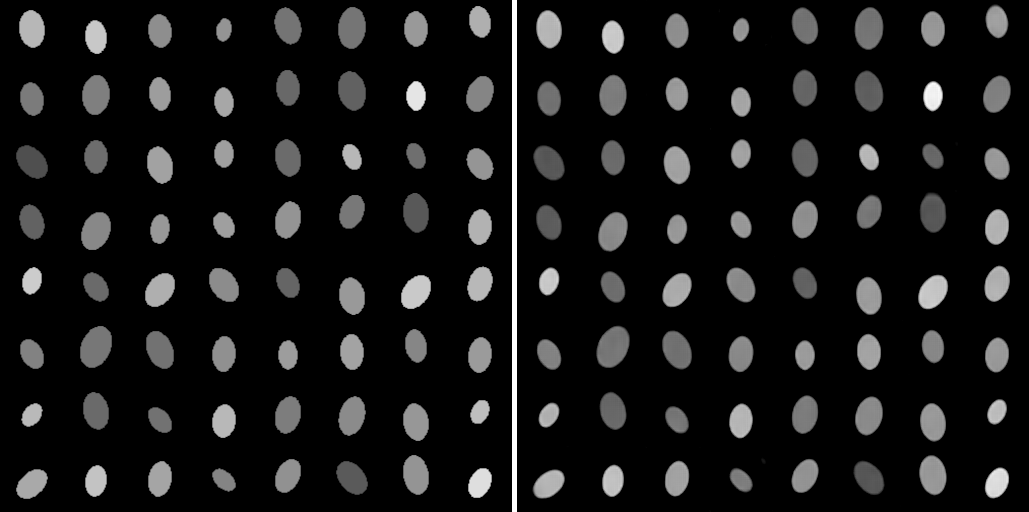

In [57]:
# first check the reconstruction images.  left: input ;   right: reconstruction
image = Image.open('./log/pvae/epoch150/test-0.png')
display(image)

In [58]:

dataloaders = get_celeba_loaders(1, 1)
with torch.no_grad():
    model.train(False)
    print(model.pe.weight)
    #exit(0)
    z_list,num_list, pos_list, rot_list, zp_list, bri_list,logit_out_list = [],[],[],[],[],[],[]


    for data in dataloaders["test"]:
        x = data[0]
        x = x.to(device)
        num_t = data[1].to(device)
        rot_t = data[2].to(device)
        pos_t = data[3].to(device)
        bri_t = data[4].to(device)
        rec_x, _, _, latent_z , zp= model(x)
        z_list.append(latent_z.unsqueeze(1))
        zp_list.append(zp.unsqueeze(1))
        bri_list.append(bri_t.unsqueeze(0))
        num_list.append(num_t.unsqueeze(0))
        rot_list.append(rot_t.unsqueeze(0))
        pos_list.append(pos_t.unsqueeze(0))

    z_list_tensor = torch.cat(z_list).squeeze(1)
    zp_list_tensor = torch.cat(zp_list).squeeze(1)
    zp_list_tensor = zp_list_tensor.squeeze(1)

    num_list_tensor = torch.cat(num_list).squeeze(1)
    bri_list_tensor = torch.cat(bri_list).squeeze(1)
    pos_list_tensor = torch.cat(pos_list).squeeze(1)
    rot_list_tensor = torch.cat(rot_list).squeeze(1)
    #exit(0)
    z_mean = torch.mean(z_list_tensor,dim=0)
    zp_mean = torch.mean(zp_list_tensor,dim=0)
    zp_std = torch.std(zp_list_tensor, dim=0)
    z_project_max,_ = torch.max(zp_list_tensor,dim=0)
    z_project_min,_ = torch.min(zp_list_tensor,dim=0)
    print('mean-3*SD, mean+3*SD:',model_lr((zp_mean-3*zp_std).unsqueeze(0)).item(), model_lr((zp_mean+3*zp_std).unsqueeze(0)).item())
    rec_tensors = torch.zeros((11,3, 64, 64))
    z_mean = z_mean.unsqueeze(0)


    flag_sampling = 1
    par_amp = 0.03
    loop_count = 0
    while flag_sampling and loop_count < 10000:      # control the sampling range to be mean+-3*SD
        loop_count = loop_count + 1
        middle_left = z_mean + par_amp*(0-5) * model.pe.weight  
        middle_right = z_mean + par_amp*(10-5) * model.pe.weight  
        middle_project_left = model.pe(middle_left)
        middle_project_right = model.pe(middle_right)
        #print(middle_project_right)
        tmp_max = torch.maximum(middle_project_left, middle_project_right)
        if torch.abs(tmp_max - (zp_mean+3*zp_std)) < 0.01:
            break
        if tmp_max - (zp_mean+3*zp_std) > 0:
            par_amp = par_amp - 0.001 
        else:
            par_amp = par_amp + 0.001

    
    points_list = []  # now start the sampling along vector p*
    for i in range(11): 
        middle = z_mean + (i-5) * model.pe.weight*par_amp 
        middle_project = model.pe(middle)
        logit_out = model_lr(middle_project)
        points_list.append(middle)
        print('brightness frame:',i+1, logit_out.item())
        rec_tensors[i] = model.decode(middle)
        rec_tensors[rec_tensors<0]=0
        rec_tensors[rec_tensors>1]=1
        imsave_inp(rec_tensors, os.path.join(logdir, f"{'frame'}-{i+1}.png"))



/home/lau/codes/env/lib/python3.6/site-packages/imgaug/imgaug.py:184: DeprecationWarning: Function `ContrastNormalization()` is deprecated. Use `imgaug.contrast.LinearContrast` instead.
  warn_deprecated(msg, stacklevel=3)


Parameter containing:
tensor([[ 0.0248,  0.0292,  1.1502, -0.0080,  0.0042,  0.0466,  0.0055,  0.0085]],
       device='cuda:1', requires_grad=True)
mean-3*SD, mean+3*SD: 0.25045332312583923 0.9186540246009827
brightness frame: 1 0.2509317696094513
brightness frame: 2 0.31765615940093994
brightness frame: 3 0.3843805491924286
brightness frame: 4 0.45110490918159485
brightness frame: 5 0.5178292989730835
brightness frame: 6 0.5845536589622498
brightness frame: 7 0.6512780785560608
brightness frame: 8 0.718002438545227
brightness frame: 9 0.7847268581390381
brightness frame: 10 0.8514512181282043
brightness frame: 11 0.9181755781173706


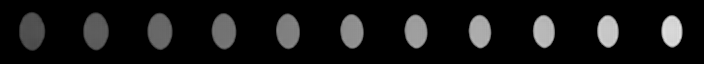

In [59]:
image = Image.open(os.path.join(logdir, f"{'frame'}-{11}.png")) # plot the 11 frames reconstructed images along vector p*
display(image) # Range: mean+- 3*SD

In [60]:
input_t_list = [0.2, 0.25, 0.3, 0.4 , 0.5, 0.6 , 0.7 , 0.8, 0.9, 0.95, 1.0] #customized input 11 values of t
input_t_list_tensor = torch.from_numpy(np.array(input_t_list)).to(device) #
value_ki_list = []
rec_tensors = torch.zeros((11,1, 64, 64))
d_mean=[]
with torch.no_grad():
    model.train(False)
        #print(model.pe.weight)
        #exit(0)
    z_list,num_list, pos_list, rot_list, zp_list, bri_list,logit_out_list = [],[],[],[],[],[],[]

    for data in dataloaders["test"]:
        x = data[0]
        x = x.to(device)
        rec_x, _, _, latent_z , zp= model(x)
        z_list.append(latent_z.unsqueeze(1))
        z_list_tensor = torch.cat(z_list).squeeze(1)

    z_mean = torch.mean(z_list_tensor,dim=0)
    d_mean_tensor = z_mean.unsqueeze(0)    
for i in range(11):
    input_t = input_t_list[10-i]
    with torch.no_grad():


        flag_sampling = 1
        value_ki = 0.03
        loop_count = 0
        while flag_sampling and loop_count < 10000:      # loop while err < 0.001, within 10000 iterations
            loop_count = loop_count + 1
            sampled_point = d_mean_tensor + value_ki * model.pe.weight # model.pe.weight is the vector p in manuscript 
            sampled_zp = model.pe(sampled_point)
            predicted_t = model_lr(sampled_zp)
            #print(middle_project_right)
            if torch.abs(input_t-predicted_t) < 0.001:
                break
            if corr_loss_bri < 0:
                if input_t-predicted_t > 0:  # if corr(zp, t)<0, flip this to: input_t-predicted_t > 0 
                    value_ki = value_ki - 0.001 
                else:
                    value_ki = value_ki + 0.001
            else:
                if input_t-predicted_t < 0:  # if corr(zp, t)<0, flip this to: input_t-predicted_t > 0 
                    value_ki = value_ki - 0.001 
                else:
                    value_ki = value_ki + 0.001

        value_ki_list = np.append(value_ki_list,value_ki)

        sampled_point = d_mean_tensor +  value_ki* model.pe.weight 
        sampled_zp = model.pe(sampled_point)
        predicted_t = model_lr(sampled_zp)
        print('The predicted brightness of frame',i+1, predicted_t.item())
        rec_tensors[i] = model.decode(sampled_point)
        rec_tensors[rec_tensors<0]=0
        rec_tensors[rec_tensors>1]=1
        imsave_inp(rec_tensors, os.path.join(logdir, f"{'frame'}-{i+1}.png"))


 


The predicted brightness of frame 1 0.9990317821502686
The predicted brightness of frame 2 0.949017345905304
The predicted brightness of frame 3 0.8990028500556946
The predicted brightness of frame 4 0.7990891337394714
The predicted brightness of frame 5 0.6990602016448975
The predicted brightness of frame 6 0.5990312695503235
The predicted brightness of frame 7 0.5009613633155823
The predicted brightness of frame 8 0.4009324312210083
The predicted brightness of frame 9 0.3009035289287567
The predicted brightness of frame 10 0.25088900327682495
The predicted brightness of frame 11 0.20098976790905


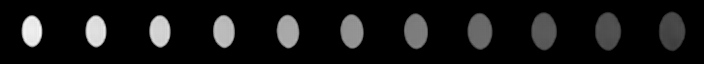

In [61]:
image = Image.open(os.path.join(logdir, f"{'frame'}-{11}.png"))
display(image)
# fix range customized by user [1.0, 0.92, 0.84, 0.76, 0.68, 0.6, 0.52, 0.44, 0.36, 0.28, 0.2]